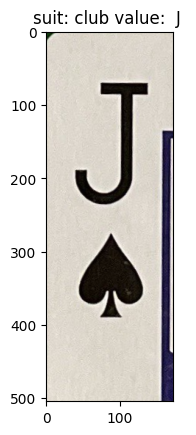

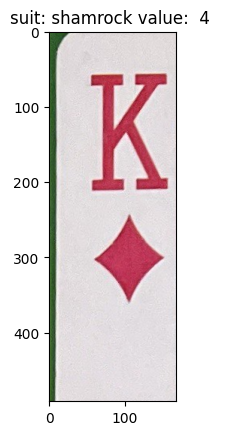

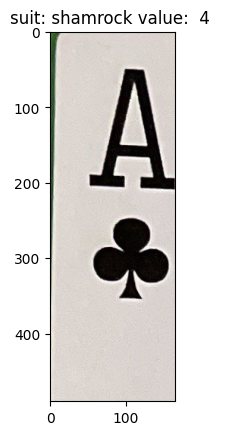

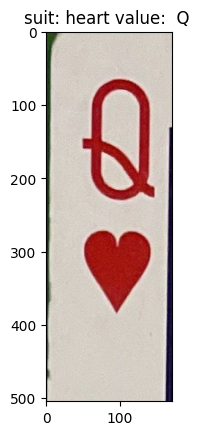

The total sum of the detected numbers is: 28
The sum is larger than 21.
Card 1: Suit - club, Value - J
Card 2: Suit - shamrock, Value - 4
Card 3: Suit - shamrock, Value - 4
Card 4: Suit - heart, Value - Q


In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def sort_contours(cnts):
    #sort contours based on contour area and then return the sorted contours
    return sorted(cnts, key=cv2.contourArea, reverse=True)

# Function to order points for perspective transform
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

# Function to perform perspective transform
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def crop_number_regions(img):
    #convert to grayscale and threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    #find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #filter out small contours
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 1000]

    #straighten each card and crop the number region
    number_regions = []
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4:
            # Straighten the card
            warped_card = four_point_transform(img, approx.reshape(4, 2))

            #crop the number region from the straightened card
            h, w = warped_card.shape[:2]
            number_region = warped_card[0:int(h * 0.35), 0:int(w * 0.17)]
            number_regions.append(number_region)

    return number_regions

def determine_contour_positions(second_largest_contour, third_largest_contour):
    #get bounding rectangles for both contours
    _, y2, _, _ = cv2.boundingRect(second_largest_contour)
    _, y3, _, _ = cv2.boundingRect(third_largest_contour)
    
    #determine which contour is below the other
    if y2 > y3:
        return second_largest_contour, third_largest_contour
    else:
        return third_largest_contour, second_largest_contour
    
    
def identify_suit(lower_contour_region, template):
    # Ensure the lower contour region is not empty
    if lower_contour_region.size == 0:
        return "Unknown"

    # Convert to grayscale for template matching
    lower_contour_region_gray = cv2.cvtColor(lower_contour_region, cv2.COLOR_BGR2GRAY)

    suit_name = None
    max_corr = 0
    
    for name, template in templates.items():
        if template is None or template.size == 0:
            continue
        
        #resized to for image to match template
        template_resized = cv2.resize(template, (lower_contour_region_gray.shape[1], lower_contour_region_gray.shape[0]))
        
        #match template and get the max val
        result = cv2.matchTemplate(lower_contour_region_gray, template_resized, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        
        #updates max_corr with this new value and sets suit_name to the current suit's name, if a better max_val is found
        if max_val > max_corr:
            max_corr = max_val
            suit_name = name

    return suit_name
    
def identify_value(number_region, number_templates):
    #converts to grayscale and applies thresholding
    gray_region = cv2.cvtColor(number_region, cv2.COLOR_BGR2GRAY)
    thresh_region = cv2.adaptiveThreshold(gray_region, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    #find contours
    contours_region, _ = cv2.findContours(thresh_region, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours_region = sort_contours(contours_region)

    if len(sorted_contours_region) > 0:
        #gets largest contour 
        largest_contour = sorted_contours_region[0]

        #crop and identify the number
        x, y, w, h = cv2.boundingRect(largest_contour)
        number_roi = number_region[y:y+h, x:x+w]
        number = match_number_template(number_roi, number_templates)

        return number
    return "Unknown"

def match_number_template(number_roi, number_templates):
    number_name = None
    max_corr = 0

    for name, template in number_templates.items():
        if template is None or template.size == 0:
            continue

        #resize so the template and the image match
        template_resized = cv2.resize(template, (number_roi.shape[1], number_roi.shape[0]))

        #check if number_roi is already a single-channel image
        if len(number_roi.shape) == 2:
            number_gray = number_roi
        else:
            number_gray = cv2.cvtColor(number_roi, cv2.COLOR_BGR2GRAY)

        #check if template_resized is already a single-channel image
        if len(template_resized.shape) == 2:
            template_gray = template_resized
        else:
            template_gray = cv2.cvtColor(template_resized, cv2.COLOR_BGR2GRAY)

        #match template and get the max val
        result = cv2.matchTemplate(number_gray, template_gray, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        
        #updates max_corr with this new value and sets suit_name to the current suit's name, if a better max_val is found
        if max_val > max_corr:
            max_corr = max_val
            number_name = name

    return number_name

#selects most probable value
def select_most_probable_value(values):
    if not values:
        return None
    return values[0]


def detect_contours(number_regions, templates):
    contour_pairs = []  

    for number_region in number_regions:
        #convert to grayscale and apply thresholding
        gray_region = cv2.cvtColor(number_region, cv2.COLOR_BGR2GRAY)
        thresh_region = cv2.adaptiveThreshold(gray_region, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        
        #find contours 
        contours_region, _ = cv2.findContours(thresh_region, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        sorted_contours_region = sort_contours(contours_region)

        if len(sorted_contours_region) > 2:
            #second and third largest contours based on the area
            second_largest_contour = sorted_contours_region[1]
            third_largest_contour = sorted_contours_region[2]
            
            lower_contour, higher_contour = determine_contour_positions(second_largest_contour, third_largest_contour)

            #crop and append the lower contour
            x, y, w, h = cv2.boundingRect(lower_contour)
            lower_contour_region = number_region[y:y+h, x:x+w]
            suit = identify_suit(lower_contour_region, templates)
            
            #crop and append the higher contour
            x, y, w, h = cv2.boundingRect(higher_contour)
            higher_contour_region = number_region[y:y+h, x:x+w]
            value = identify_value(number_region, number_templates)
            most_probable_value = select_most_probable_value(value) 
            
            contour_pairs.append((suit, most_probable_value))

            #display contours
            debug_image = number_region.copy()
            #cv2.drawContours(debug_image, [lower_contour], -1, (0, 255, 0), 3)  
            #cv2.drawContours(debug_image, [higher_contour], -1, (255, 0, 0), 3) 
            plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB))
            plt.title(f"suit: {suit} value:  {value} ")

            plt.show()
            
    return contour_pairs

#print card values
def print_contour_pairs(contour_pairs):
    for i, (suit, value) in enumerate(contour_pairs):
        print(f"Card {i+1}: Suit - {suit}, Value - {value}")

def game_logic(contour_pairs):
    total_sum = 0
    
    #assign score values
    for suit, number in contour_pairs:
        if number == 'J' or number == 'Q' or number == 'K':
            total_sum += 10
        elif number == 'A':
            total_sum += 1  
        elif number.isdigit():
            total_sum += int(number)
            
    #sum the cards in play
    print(f"The total sum of the detected numbers is: {total_sum}")

    #print result
    if total_sum < 21:
       result =  print("The sum is smaller than 21.")
    elif total_sum > 21:
       result = print("The sum is larger than 21.")
    else:
       result = print("You won the game!")
    return result

# Load the image from file
img = cv2.imread("cards_green.jpg")

templates = {
    'heart': cv2.imread('heart.jpg', 0),
    'diamond': cv2.imread('diamond.jpg', 0),
    'club': cv2.imread('club.jpg', 0),
    'shamrock': cv2.imread('shamrock.jpg', 0)
}

number_templates = {

    'J' : cv2.imread('J.png', cv2.IMREAD_GRAYSCALE),
    'K' : cv2.imread('K.png', cv2.IMREAD_GRAYSCALE),
    'Q' : cv2.imread('Q.png', cv2.IMREAD_GRAYSCALE),
    'A' : cv2.imread('A.png', cv2.IMREAD_GRAYSCALE),
    '3' : cv2.imread('num3.png', cv2.IMREAD_GRAYSCALE),
    '4' : cv2.imread('num4.png', cv2.IMREAD_GRAYSCALE),
    '5' : cv2.imread('num5.png', cv2.IMREAD_GRAYSCALE),
    '9' : cv2.imread('num9.png', cv2.IMREAD_GRAYSCALE),
    '2' : cv2.imread('num2.jpg', cv2.IMREAD_GRAYSCALE),
    '8' : cv2.imread('num8.jpg', cv2.IMREAD_GRAYSCALE),
    '10' : cv2.imread('num10.jpg', cv2.IMREAD_GRAYSCALE),
    '7' : cv2.imread('num7.jpg', cv2.IMREAD_GRAYSCALE),
    '6' : cv2.imread('num6.jpg', cv2.IMREAD_GRAYSCALE)
}


images_to_compare = [number_templates['J'], number_templates['K'], number_templates['Q'], number_templates['A'],
                     number_templates['3'], number_templates['4'], number_templates['5'], number_templates['9'], number_templates['2'],
                     number_templates['8'], number_templates['10'], number_templates['7'], number_templates['6']]
characters = ['J', 'K', 'Q', 'A', '3', '4', '5', '9', '2', '8', '10', '7', '6']


# Use the function to get the number regions
number_regions = crop_number_regions(img)

contour_pairs = detect_contours(number_regions, templates)

result = game_logic(contour_pairs)

print_contour_pairs(contour_pairs)